In [1]:
from matplotlib import pyplot as plt
import numpy as np
from iminuit import Minuit
from iminuit.cost import LeastSquares
import math

In [2]:
evt_x = np.loadtxt("data/fit-data-1.txt")

In [3]:
evt_x.max()

97.05734290236616

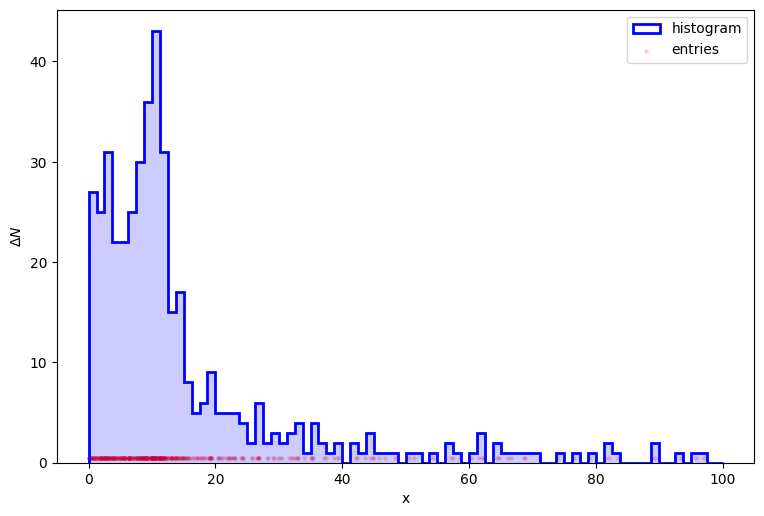

In [4]:
fig, ax = plt.subplots(figsize=(9,6),dpi=100)
n_bins = 80
x_range = (0, 100)
data_y, bins, patches = ax.hist(evt_x, n_bins, range=x_range, density=False, 
    histtype=u'step', edgecolor='b', linewidth=2, label='histogram')
ax.hist(evt_x, n_bins, range=x_range, density=False, color='b', alpha=0.2)
ax.scatter(evt_x, np.full_like(evt_x, 0.5), marker='o', color='r', s=10, alpha=0.2, linewidth=0, label='entries')
plt.xlabel('x')
plt.ylabel('$\Delta N$')
plt.legend()
plt.show()

In [5]:
#bins

In [6]:
data_x = (bins+(bins[1]-bins[0])/2)[:-1]
#print(data_x)

In [7]:
data_yerr = np.sqrt(data_y)
#print(data_y)
#print(data_yerr)

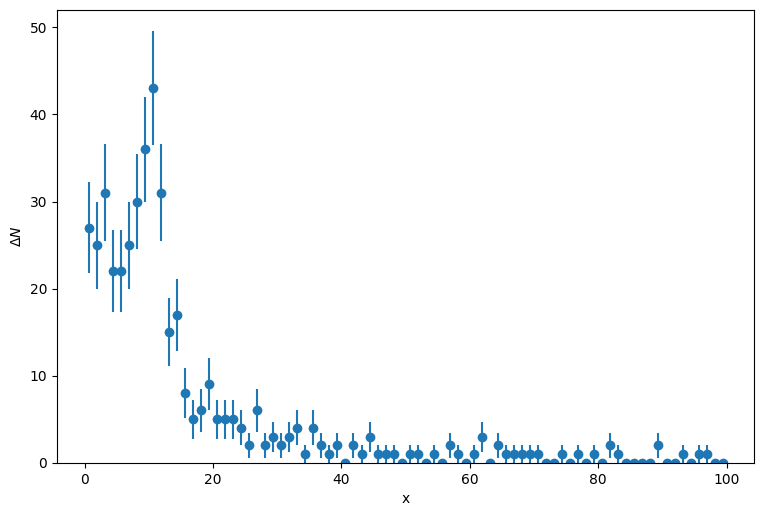

In [8]:
plt.figure(figsize=(9,6),dpi=100)
plt.errorbar(data_x, data_y, data_yerr, fmt="o")
plt.xlabel('x')
plt.ylabel('$\Delta N$')
plt.ylim(0)
plt.show()

In [9]:
def bkg_pdf(x, par):
    return np.exp(-x/par[0])/par[0]
def sig_pdf(x, par):
    return np.exp(-((x-par[0])/par[1])**2/2)/math.sqrt(2*math.pi*par[1]**2)
def bkg_model(x, par):
    return par[0]*bkg_pdf(x, par[1:])
def sig_model(x, par):
    return par[0]*sig_pdf(x, par[1:])
def fit_model(x, par):
    return bkg_model(x, par)+sig_model(x, par[2:])

In [10]:
least_squares_mode = LeastSquares(data_x[data_y>0], data_y[data_y>0], data_yerr[data_y>0], fit_model)
m = Minuit(least_squares_mode, (500,5,100,10,2), name=("B", "$\lambda$", "S", "$\mu$", "$\sigma$"))

In [11]:
m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 39.17                      │              Nfcn = 200              │
│ EDM = 4.6e-06 (Goal: 0.0002)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ B         │    377    │    28     │            │            │         │         │       │
│ 1 │ $\lambda$ │   13.1    │    1.1    │            │            │         │         │       │
│ 2 │ S         │    129    │    22     │            │            │         │         │       │
│ 3 │ $\mu$     │   10.14   │   0.34    │            │            │         │         │       │
│ 4 │ $\sigma$  │    1.9    │    0.4    │            │            │         │         │       │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────┬───────────────────────────────────────────────────┐
│           │         B $\lambda$         S     $\mu$  $\sigma$ │
├───────────┼───────────────────────────────────────────────────┤
│         B │       811     -3.65      -333      2.01     -4.47 │
│ $\lambda$ │     -3.65      1.26      5.26   -0.0767    0.0789 │
│         S │      -333      5.26       496     -2.09      4.51 │
│     $\mu$ │      2.01   -0.0767     -2.09     0.114   -0.0478 │
│  $\sigma$ │     -4.47    0.0789      4.51   -0.0478     0.134 │
└───────────┴───────────────────────────────────────────────────┘

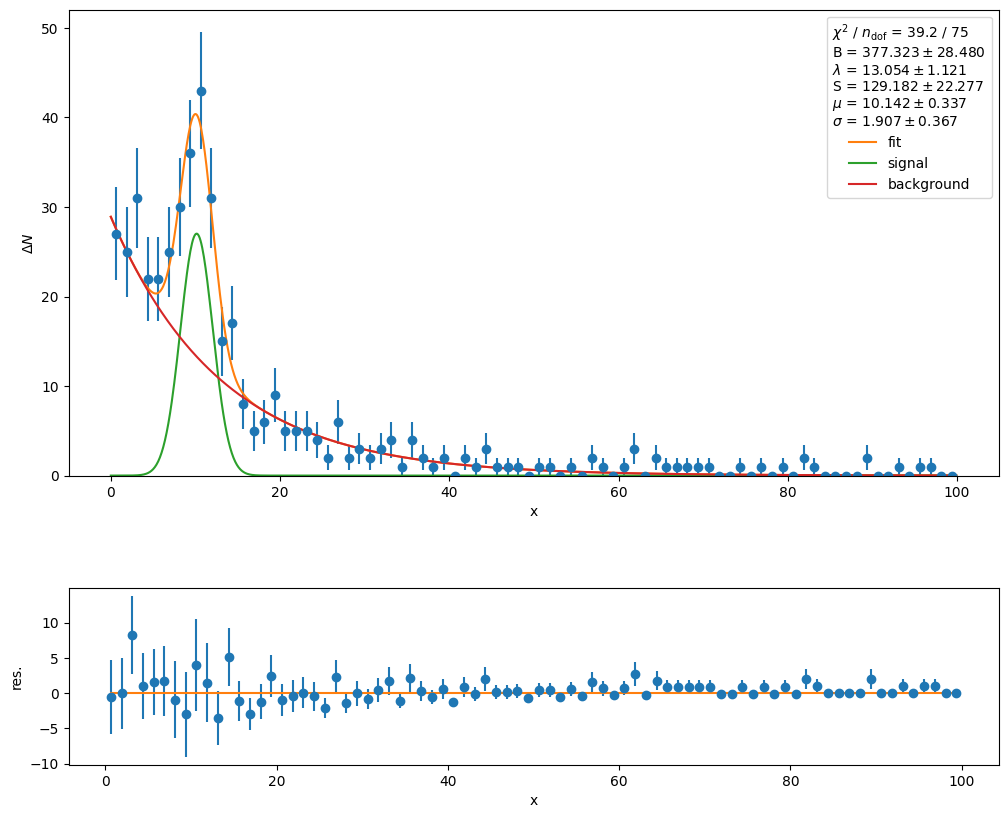

In [12]:
import matplotlib.gridspec as gridspec
data_x_f = np.arange(0, bins[-1], 0.1)
data_y_f = fit_model(data_x_f, m.values)
bkg_y_f = bkg_model(data_x_f, m.values)
sig_y_f = sig_model(data_x_f, m.values[2:])

plt.figure(figsize=(12,10),dpi=100)
gs = gridspec.GridSpec(8, 1)
ax0 = plt.subplot(gs[:5, :])
ax1 = plt.subplot(gs[6:, :])
ax0.errorbar(data_x, data_y, data_yerr, fmt="o")
ax0.plot(data_x_f, data_y_f, label="fit")
ax0.plot(data_x_f, sig_y_f, label="signal")
ax0.plot(data_x_f, bkg_y_f, label="background")
ax0.set_xlabel('x')
ax0.set_ylabel('$\Delta N$')
ax1.errorbar(data_x, data_y-fit_model(data_x, m.values), data_yerr, fmt="o")
ax1.plot([data_x[0],data_x[-1]], [0,0])
ax1.set_xlabel('x')
ax1.set_ylabel('res.')
ax0.set_ylim(0)
ax.legend()

fit_info = [ f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(data_x) - m.nfit}" ]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")
ax0.legend(title="\n".join(fit_info))
plt.show()

## Unbinned (meno conveniente)

In [13]:
def neg_log_like_fun(par):
    b, l, s, mu, sigma = par
    lik = s + b
    for x in evt_x:
        fs = sig_pdf(x, [mu, sigma])
        fb = bkg_pdf(x, [l])
        lik -= math.log(s*fs + b*fb)
    return lik
neg_log_like_fun.errordef = Minuit.LIKELIHOOD 
g = Minuit(neg_log_like_fun, (500,5,100,10,2), name=("B", "$\lambda$", "S", "$\mu$", "$\sigma$"))

In [14]:
g.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -633.2                     │              Nfcn = 216              │
│ EDM = 3.3e-07 (Goal: 0.0001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ B         │    345    │    25     │            │            │         │         │       │
│ 1 │ $\lambda$ │   16.6    │    1.0    │            │            │         │         │       │
│ 2 │ S         │    95     │    20     │            │            │         │         │       │
│ 3 │ $\mu$     │   10.09   │   0.33    │            │            │         │         │       │
│ 4 │ $\sigma$  │    1.7    │    0.5    │            │            │         │         │       │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────┬───────────────────────────────────────────────────┐
│           │         B $\lambda$         S     $\mu$  $\sigma$ │
├───────────┼───────────────────────────────────────────────────┤
│         B │       640     -6.21      -296      2.14      -6.4 │
│ $\lambda$ │     -6.21     0.938      6.21   -0.0616     0.138 │
│         S │      -296      6.21       391     -2.15       6.4 │
│     $\mu$ │      2.14   -0.0616     -2.15     0.106   -0.0596 │
│  $\sigma$ │      -6.4     0.138       6.4   -0.0596     0.214 │
└───────────┴───────────────────────────────────────────────────┘

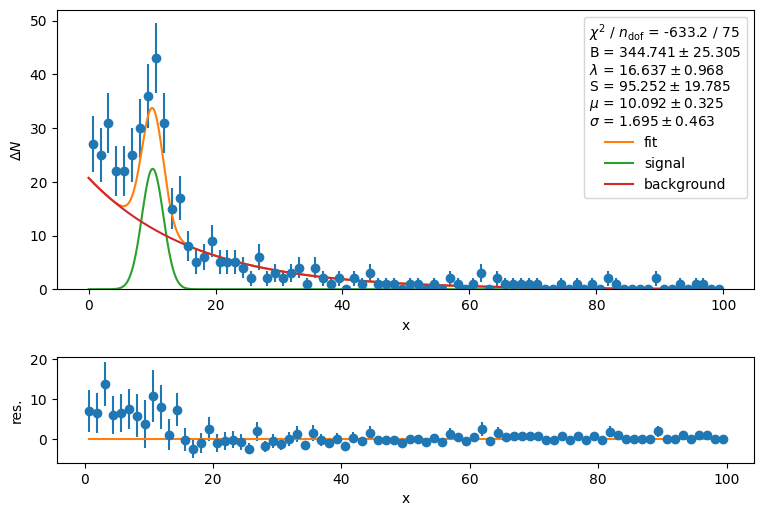

In [15]:
data_x_f = np.arange(0, bins[-1], 0.1)
data_y_f = fit_model(data_x_f, g.values)
bkg_y_f = bkg_model(data_x_f, g.values)
sig_y_f = sig_model(data_x_f, g.values[2:])

plt.figure(figsize=(9,6),dpi=100)
gs = gridspec.GridSpec(8, 1)
ax0 = plt.subplot(gs[:5, :])
ax1 = plt.subplot(gs[6:, :])
ax0.errorbar(data_x, data_y, data_yerr, fmt="o")
ax0.plot(data_x_f, data_y_f, label="fit")
ax0.plot(data_x_f, sig_y_f, label="signal")
ax0.plot(data_x_f, bkg_y_f, label="background")
ax0.set_xlabel('x')
ax0.set_ylabel('$\Delta N$')
ax1.errorbar(data_x, data_y-fit_model(data_x, g.values), data_yerr, fmt="o")
ax1.plot([data_x[0],data_x[-1]], [0,0])
ax1.set_xlabel('x')
ax1.set_ylabel('res.')
ax0.set_ylim(0)
fit_info = [ f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {g.fval:.1f} / {len(data_x) - g.nfit}" ]
for p, v, e in zip(g.parameters, g.values, g.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")
ax0.legend(title="\n".join(fit_info))
plt.show()